### Step 6.  Sentiment Analysis

#### Import submissions and comments from prior steps

In [ ]:
!ls

In [1]:
import pandas as pd

In [3]:
tfcc_data = pd.read_csv('tfcc_submissions_selected_topics_neg1.csv')
tfcc_comments = pd.read_csv('tfcc_comments.csv')


#### Cleanup the comments dataframe by removing the first three characters (this will allow association with the original submission and rename body to selftext)

In [4]:
tfcc_comments = tfcc_comments.rename(columns={'body': 'selftext'})
tfcc_comments['parent_id'] = tfcc_comments['parent_id'].str[3:]

#### Filter comments to only include those which have a parent in the submissions data - this will reduce the total number of comments substantially

In [5]:
# get the number of rows using the shape attribute
start_num_rows = tfcc_comments.shape[0]

# print the number of rows
tfcc_comments = tfcc_comments[tfcc_comments['parent_id'].isin(tfcc_data['id'])]
end_num_rows = tfcc_comments.shape[0]

print("Total rows in comments reduced from " + str(start_num_rows) + " to " + str(end_num_rows))


Total rows in comments reduced from 76848 to 3010


#### Check the sentiment of each row in the submissions dataframe.  Break up the submissions if they are > 512 tokens and then combine the results into a single sentiment score.  Finally, update each row with the sentiment values.  

In [6]:
from transformers import pipeline, DistilBertTokenizerFast
import numpy as np
import torch
from tqdm import tqdm

import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")


sentiment_classifier = pipeline(
    model="distilbert-base-uncased-finetuned-sst-2-english",
    task="sentiment-analysis",
    top_k=None,
    device=0 if torch.cuda.is_available() else -1,  # Set device to GPU if available, otherwise use CPU
)


tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def get_sentiment(row):
    text = row['selftext']
    chunk_size = 512  # number of tokens per chunk
    token_chunks = []
    for i in range(0, len(text), chunk_size):
        chunk = text[i:i+chunk_size]
        tokens = tokenizer.encode_plus(
            chunk,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=chunk_size,
            return_tensors='pt'
        )
        token_chunks.append(tokens)

    # Analyze sentiment for each chunk
    pos_scores = []
    neg_scores = []
    
    batch_size = 8
    num_batches = len(token_chunks) // batch_size + int(len(token_chunks) % batch_size > 0)

    for batch_idx in tqdm(range(num_batches), desc=f"Processing row {row.name}"):
        batch_start = batch_idx * batch_size
        batch_end = (batch_idx + 1) * batch_size
        batch = token_chunks[batch_start:batch_end]

        input_ids = torch.cat([tokens['input_ids'] for tokens in batch], dim=0).to(device)
        attention_mask = torch.cat([tokens['attention_mask'] for tokens in batch], dim=0).to(device)

        #input_ids = torch.cat([tokens['input_ids'] for tokens in batch], dim=0)
        #attention_mask = torch.cat([tokens['attention_mask'] for tokens in batch], dim=0)

        try:
            with torch.no_grad():
                response = sentiment_classifier.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
            logits = response.logits
            scores = torch.softmax(logits, dim=-1).tolist()
            pos_scores.extend([score[1] for score in scores])
            neg_scores.extend([score[0] for score in scores])
        except Exception as e:
            print(f"Error occurred in row {row.name}: {e}")
            row['pos_sentiment'] = np.nan
            row['neg_sentiment'] = np.nan
            return row

    # Average the sentiment scores
    avg_pos_sentiment = sum(pos_scores) / len(pos_scores)
    avg_neg_sentiment = sum(neg_scores) / len(neg_scores)
    row['pos_sentiment'] = avg_pos_sentiment
    row['neg_sentiment'] = avg_neg_sentiment

    return row


Using GPU


In [7]:
tfcc_data = tfcc_data.apply(get_sentiment, axis=1)


Processing row 1190: 100%|██████████| 1/1 [00:00<00:00, 31.71it/s]


#### Print the first few rows to confirm the sentiment values have been added

In [8]:
tfcc_data.head()

,id,title,selftext,author,score,num_comments,created_date,selftext_length,topic,pos_sentiment,neg_sentiment
0,ymjc0,"Tech support agent, and yet I can't touch my c...",at my work we are not allowed to adjust the mo...,hanzors,40,19,2012-08-22 06:27:29,104,1,0.002825,0.997175
1,10mbtu,Passwords,"so i work for a major cellphone company, my se...",[deleted],19,12,2012-09-28 14:41:55,245,17,0.000301,0.999699
2,10qjhg,"""Treat me like a friend.""","got a customer the other day who, in the middl...",TroubleEntendre,37,9,2012-10-01 00:53:29,104,12,0.015125,0.984875
3,10vp4l,Any stories/rants from chat reps?,i am a chat rep for a major financial firm. i ...,solidsnake78,11,11,2012-10-03 15:58:30,300,9,0.185134,0.814866
4,11ddgv,Good universal script for transferring a call?,"not sure if this is the best place to ask, but...",beepbeep27,7,23,2012-10-12 16:16:57,107,19,0.003420,0.996580


#### Export the results to a CSV

In [9]:
tfcc_data.to_csv('tfcc_submissions_neg1_with_sentiment.csv', index=False)


#### Perform sentiment analysis on comments

In [10]:
tfcc_comments = tfcc_comments.apply(get_sentiment, axis=1)
tfcc_comments

Processing row 76734: 100%|██████████| 1/1 [00:00<00:00, 92.67it/s]


,parent_id,selftext,score,pos_sentiment,neg_sentiment
3,ymjc0,"this makes me like my call center, everything ...",3.0,0.997643,0.002357
22,ymjc0,we get this at work. our computers are in kios...,2.0,0.001411,0.998589
33,10mbtu,I used to work for a company that allowed cust...,5.0,0.000850,0.999150
42,10vp4l,I was one for awhile. \n\nI was a master at co...,4.0,0.002030,0.997970
60,11ddgv,"We dont have a script for transfers, but our b...",1.0,0.003542,0.996458
...,...,...,...,...,...
76415,zh95z0,"Two words: malicious compliance.\n\nExample, a...",1.0,0.512640,0.487360
76435,zh95z0,I unfortunately work in debt collection and I ...,2.0,0.000309,0.999691
76562,zp0w7a,"Not a call center story, but I once was workin...",41.0,0.000814,0.999186
76566,zp0w7a,My wife used to work graveyard shift at WalMar...,33.0,0.002857,0.997142


#### Update comments dataframe sentiment column names

In [11]:
tfcc_comments = tfcc_comments.rename(columns={'pos_sentiment': 'comments_pos_sentiment'})
tfcc_comments = tfcc_comments.rename(columns={'neg_sentiment': 'comments_neg_sentiment'})
tfcc_comments

,parent_id,selftext,score,comments_pos_sentiment,comments_neg_sentiment
3,ymjc0,"this makes me like my call center, everything ...",3.0,0.997643,0.002357
22,ymjc0,we get this at work. our computers are in kios...,2.0,0.001411,0.998589
33,10mbtu,I used to work for a company that allowed cust...,5.0,0.000850,0.999150
42,10vp4l,I was one for awhile. \n\nI was a master at co...,4.0,0.002030,0.997970
60,11ddgv,"We dont have a script for transfers, but our b...",1.0,0.003542,0.996458
...,...,...,...,...,...
76415,zh95z0,"Two words: malicious compliance.\n\nExample, a...",1.0,0.512640,0.487360
76435,zh95z0,I unfortunately work in debt collection and I ...,2.0,0.000309,0.999691
76562,zp0w7a,"Not a call center story, but I once was workin...",41.0,0.000814,0.999186
76566,zp0w7a,My wife used to work graveyard shift at WalMar...,33.0,0.002857,0.997142


#### Export the comments dataframe to a CSV

In [12]:
tfcc_comments.to_csv('tfcc_comments_neg1_with_sentiment.csv', index=False)


#### Add a column to the submissions dataframe that shows the average sentiment of comments.  If value is NaN that means the comment was deleted in a prior step because it was too short.

In [13]:
# Calculate the average sentiment for each parent_id in tfcc_comments
sentiment_means = tfcc_comments.groupby('parent_id')[['comments_pos_sentiment', 'comments_neg_sentiment']].mean()


In [14]:
tfcc_data = pd.merge(tfcc_data, sentiment_means, how='left', left_on='id', right_on='parent_id')


In [15]:
tfcc_data

,id,title,selftext,author,score,num_comments,created_date,selftext_length,topic,pos_sentiment,neg_sentiment,comments_pos_sentiment,comments_neg_sentiment
0,ymjc0,"Tech support agent, and yet I can't touch my c...",at my work we are not allowed to adjust the mo...,hanzors,40,19,2012-08-22 06:27:29,104,1,0.002825,0.997175,0.499527,0.500473
1,10mbtu,Passwords,"so i work for a major cellphone company, my se...",[deleted],19,12,2012-09-28 14:41:55,245,17,0.000301,0.999699,0.486922,0.513078
2,10qjhg,"""Treat me like a friend.""","got a customer the other day who, in the middl...",TroubleEntendre,37,9,2012-10-01 00:53:29,104,12,0.015125,0.984875,0.005683,0.994317
3,10vp4l,Any stories/rants from chat reps?,i am a chat rep for a major financial firm. i ...,solidsnake78,11,11,2012-10-03 15:58:30,300,9,0.185134,0.814866,0.330938,0.669062
4,11ddgv,Good universal script for transferring a call?,"not sure if this is the best place to ask, but...",beepbeep27,7,23,2012-10-12 16:16:57,107,19,0.003420,0.996580,0.158013,0.841987
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1186,z8k8s6,"Be careful what you ask for, you just might ge...","i work in a call centre. it's a small-ish, fam...",ig0tst0ries,106,7,2022-11-30 06:52:58,312,18,0.001417,0.998583,0.001027,0.998973
1187,zdhg4r,Most irritating survey response,i had this call with this woman where i did ev...,Toritoise,280,64,2022-12-05 19:50:53,186,0,0.010150,0.989850,0.033904,0.966096
1188,zh95z0,How do you combat the urge to assume everyone’...,i work at a utility company. people call in ...,gameofthrones_addict,93,49,2022-12-09 21:23:33,355,2,0.202738,0.797262,0.149443,0.850557
1189,zp0w7a,"If anyone DOESNT need knives, it’s him.","before where i am now, i was customer service ...",bremariemantis,170,11,2022-12-18 15:19:39,252,14,0.331560,0.668440,0.001836,0.998164


#### Export the updated dataframe to CSV

In [16]:
tfcc_data.to_csv('tfcc_submissions_neg1_with_sentiment_including_comment_sentiment.csv', index=False)


#### Retrieve the topics rollup created in prior steps

In [18]:
tfcc_topics = pd.read_csv('tfcc_submissions_topic_counts_neg1')


In [19]:
tfcc_topics
tfcc_topics = tfcc_topics.loc[(tfcc_topics['Topic'] != -1) & (tfcc_topics['Topic'] <= 19)]


In [20]:
tfcc_topics

,Topic,Count,Name
1,0,165,0_name_thank_need_lady
2,1,119,1_support_tech_software_device
3,2,99,2_payments_refund_bank_card
4,3,89,3_insurance_claim_car_name
5,4,66,4_bill_credit_people_payment
6,5,65,5_client_number_order_address
7,6,58,6_feel_jobs_life_centers
8,7,58,7_customers_service_screaming_like
9,8,57,8_service_amp_credit_isp
10,9,53,9_amp_chat_harry_gbl


#### Update the topics rollup to include overall sentiment of the posts and comments associated with each topic

In [21]:
# Group tfcc_data by topic and calculate the mean sentiment scores and comment averages
sentiment_by_topic = tfcc_data.groupby('topic').agg({'pos_sentiment': 'mean', 'neg_sentiment': 'mean', 'comments_pos_sentiment': 'mean', 'comments_neg_sentiment': 'mean'})

# Rename the columns for clarity
sentiment_by_topic = sentiment_by_topic.rename(columns={'pos_sentiment': 'avg_pos_sentiment', 'neg_sentiment': 'avg_neg_sentiment', 'comments_pos_sentiment': 'avg_comments_pos_sentiment', 'comments_neg_sentiment': 'avg_comments_neg_sentiment'})

# Merge the average sentiment scores and comment averages into tfcc_topics by matching on the topic column
tfcc_topics = tfcc_topics.merge(sentiment_by_topic, left_on='Topic', right_index=True)





In [22]:
tfcc_topics.head(20)

,Topic,Count,Name,avg_pos_sentiment,avg_neg_sentiment,avg_comments_pos_sentiment,avg_comments_neg_sentiment
1,0,165,0_name_thank_need_lady,0.245925,0.754075,0.197364,0.802636
2,1,119,1_support_tech_software_device,0.115113,0.884887,0.149953,0.850047
3,2,99,2_payments_refund_bank_card,0.090787,0.909213,0.093408,0.906592
4,3,89,3_insurance_claim_car_name,0.122402,0.877598,0.187969,0.812031
5,4,66,4_bill_credit_people_payment,0.112709,0.887291,0.141821,0.858179
6,5,65,5_client_number_order_address,0.066668,0.933332,0.152198,0.847802
7,6,58,6_feel_jobs_life_centers,0.285938,0.714062,0.377832,0.622168
8,7,58,7_customers_service_screaming_like,0.085788,0.914212,0.147586,0.852414
9,8,57,8_service_amp_credit_isp,0.061602,0.938398,0.137942,0.862058
10,9,53,9_amp_chat_harry_gbl,0.266073,0.733927,0.211665,0.788335


#### Create a bar chart that shows the relationship between submission and comments sentiment by topic

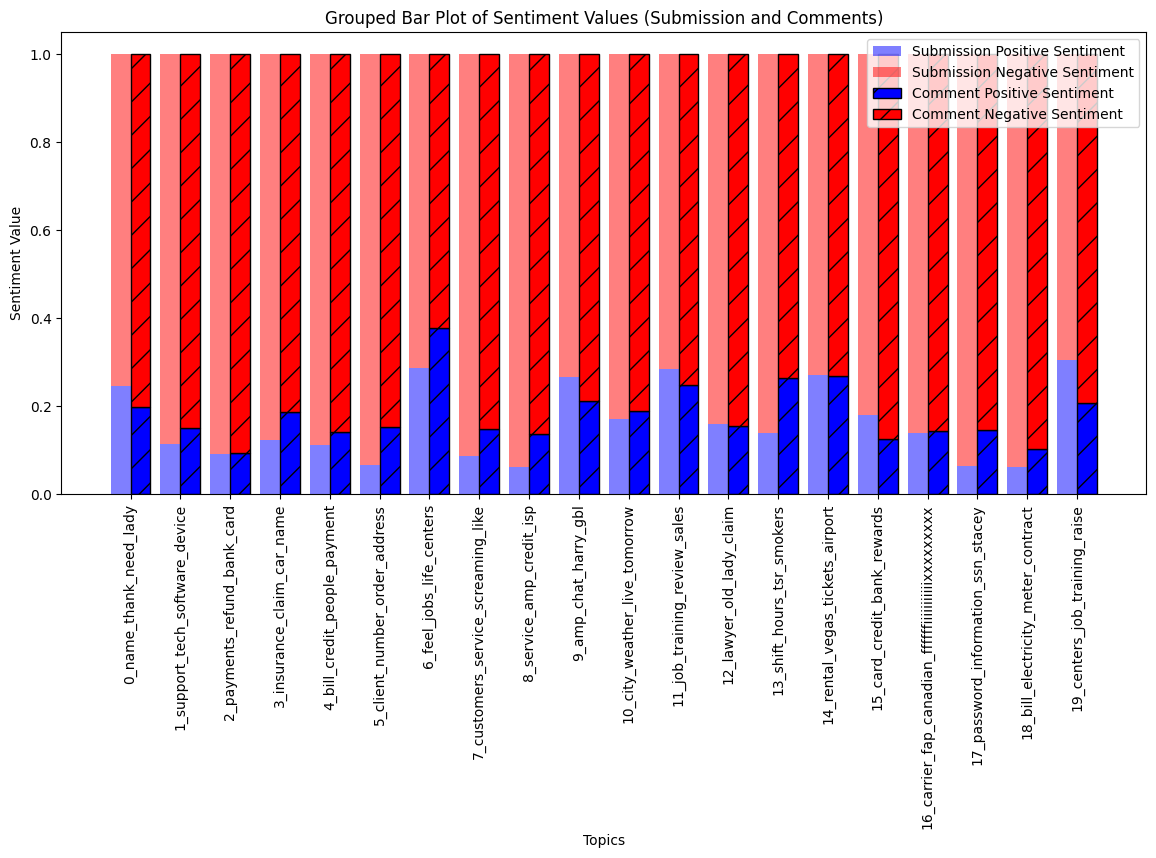

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = tfcc_topics

# Grouped bar plot
n_topics = len(data)
index = np.arange(n_topics)
bar_width = 0.4

plt.figure(figsize=(14, 6))

# Submission sentiments
plt.bar(index, data['avg_pos_sentiment'], bar_width, label='Submission Positive Sentiment', color='blue', alpha=0.5)
plt.bar(index, data['avg_neg_sentiment'], bar_width, label='Submission Negative Sentiment', color='red', alpha=0.5, bottom=data['avg_pos_sentiment'])

# Comment sentiments
plt.bar(index + bar_width, data['avg_comments_pos_sentiment'], bar_width, label='Comment Positive Sentiment', color='blue', hatch='/', edgecolor='black')
plt.bar(index + bar_width, data['avg_comments_neg_sentiment'], bar_width, label='Comment Negative Sentiment', color='red', hatch='/', edgecolor='black', bottom=data['avg_comments_pos_sentiment'])

plt.xticks(index + bar_width / 2, data['Name'], rotation=90)
plt.ylabel('Sentiment Value')
plt.xlabel('Topics')
plt.legend()
plt.title('Grouped Bar Plot of Sentiment Values (Submission and Comments)')
plt.show()

In [24]:
tfcc_topics.to_csv('tfcc_neg1_topics_with_sentiment_and_comments_sentiment.csv', index=False)
